## Project Overview
This notebook builds a machine learning classification model to predict heart disease using the Kaggle Heart Failure Prediction dataset. It covers data loading, data cleaning, exploratory data analysis (EDA), feature engineering, model development (Logistic Regression and Random Forest), evaluation, and insights.

#### How to Use This Notebook

1. Download the dataset from Kaggle:
https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

2. Save the file in the same directory as this notebook and rename it to heart.csv.

3. Run the notebook sequentially in Jupyter Notebook or Google Colab.

4. If using Google Colab, upload heart.csv to the runtime or mount Google Drive.

In [2]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [4]:
# 2. Load dataset
df = pd.read_csv("heart.csv")

df.shape

(918, 12)

In [5]:
# 3. Quick look
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
df.info()
print('\nMissing values per column:')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB

Missing values per column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina

In [7]:
# 5. Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


Using target column: HeartDisease


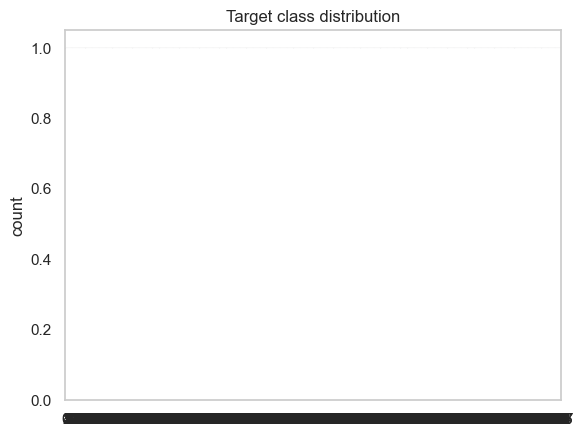

In [8]:
# 6. Target distribution
target_col = 'target' if 'target' in df.columns else 'DEATH_EVENT' if 'DEATH_EVENT' in df.columns else df.columns[-1]
print('Using target column:', target_col)
sns.countplot(df[target_col])
plt.title('Target class distribution')
plt.show()

In [10]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

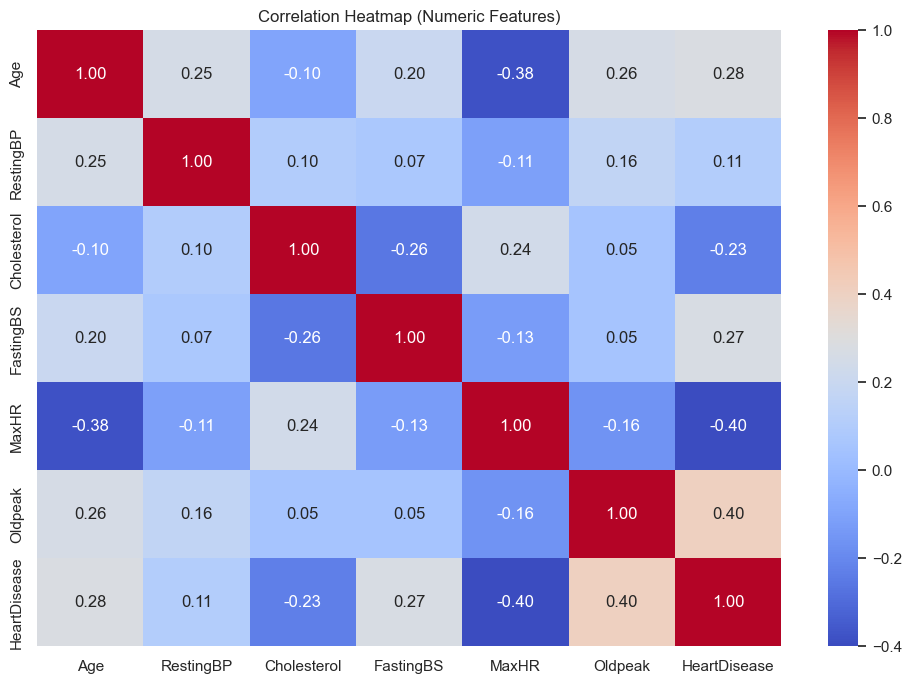

In [11]:
# Correlation Heatmap (Numeric Features Only)
plt.figure(figsize=(12,8))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()


Since correlation requires numerical inputs, only numeric features were considered in this heatmap. Categorical features (Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope) were excluded to avoid conversion errors. This provides a clean and interpretable correlation structure among the core numerical variables.

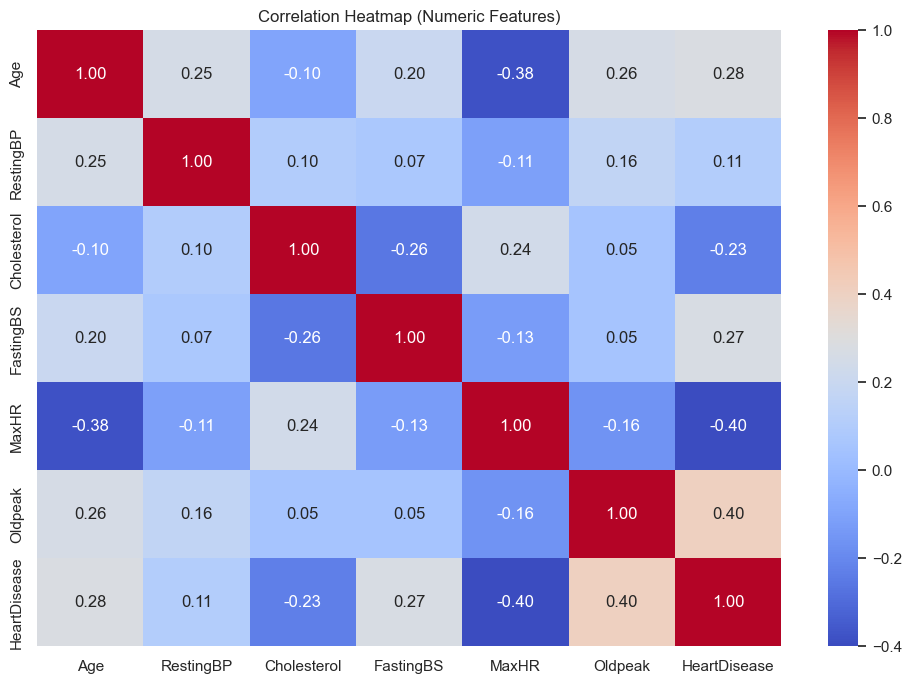

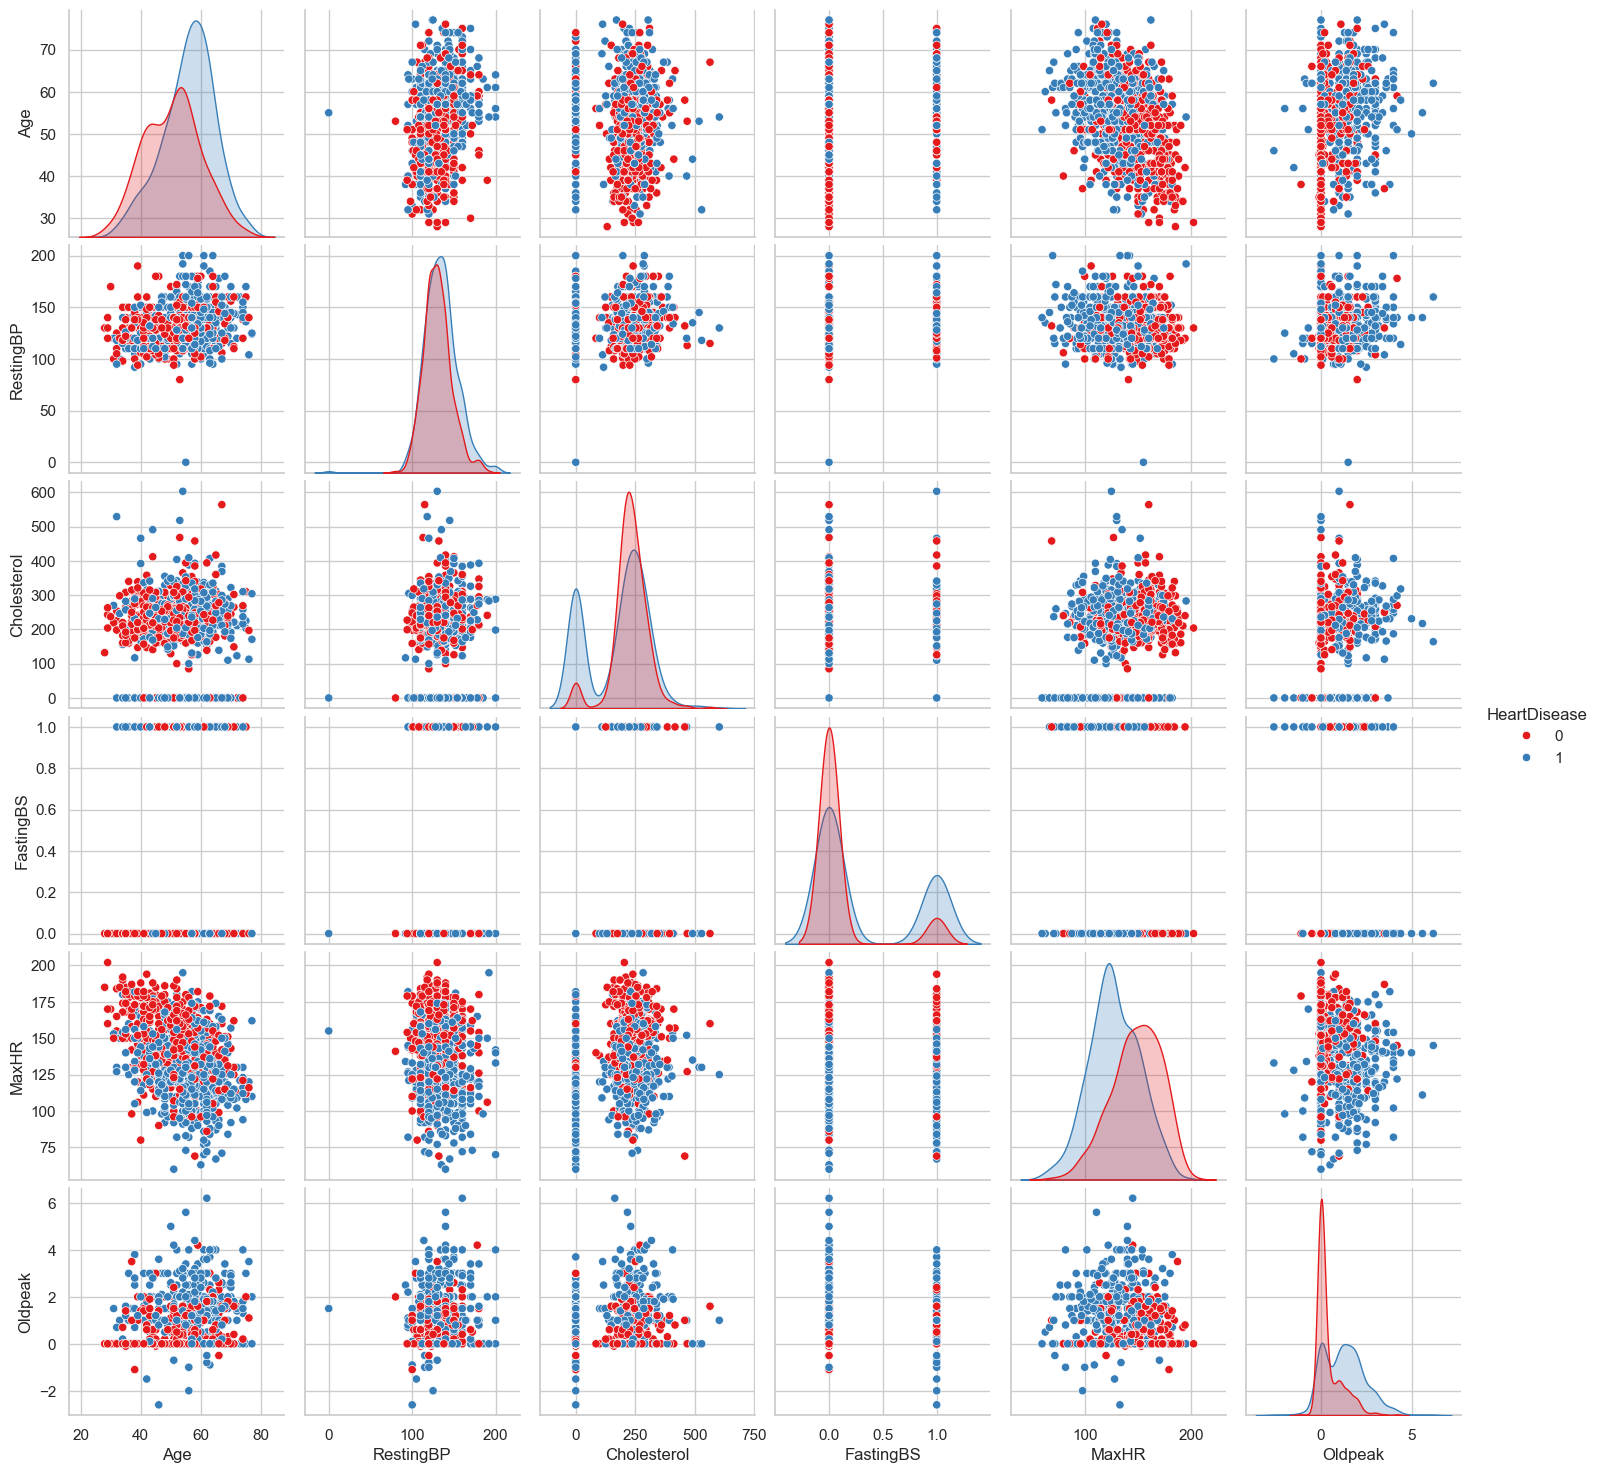

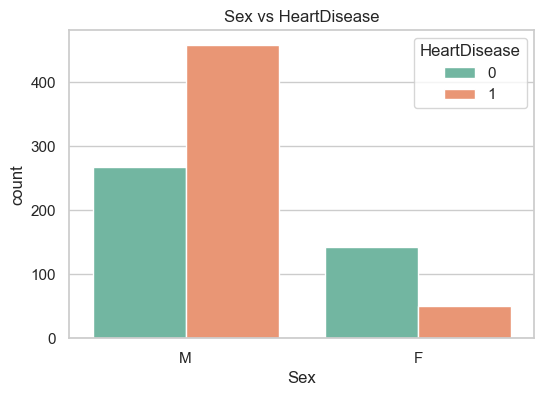

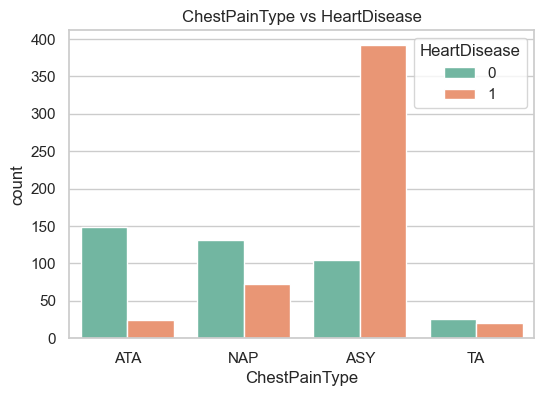

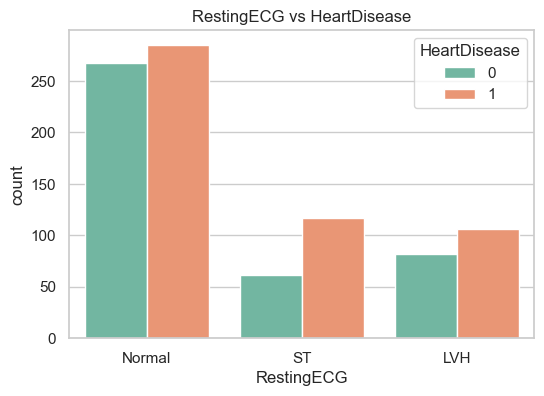

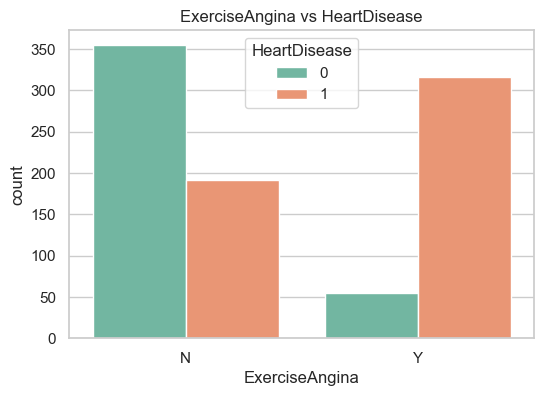

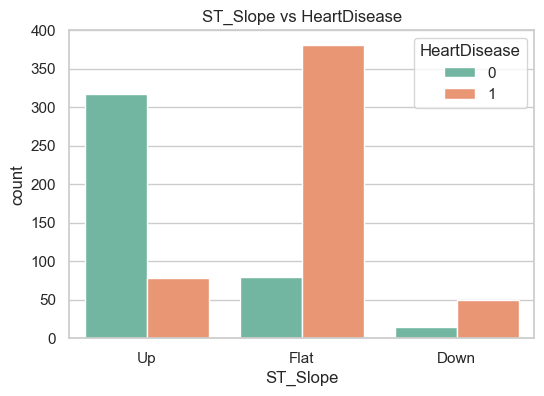

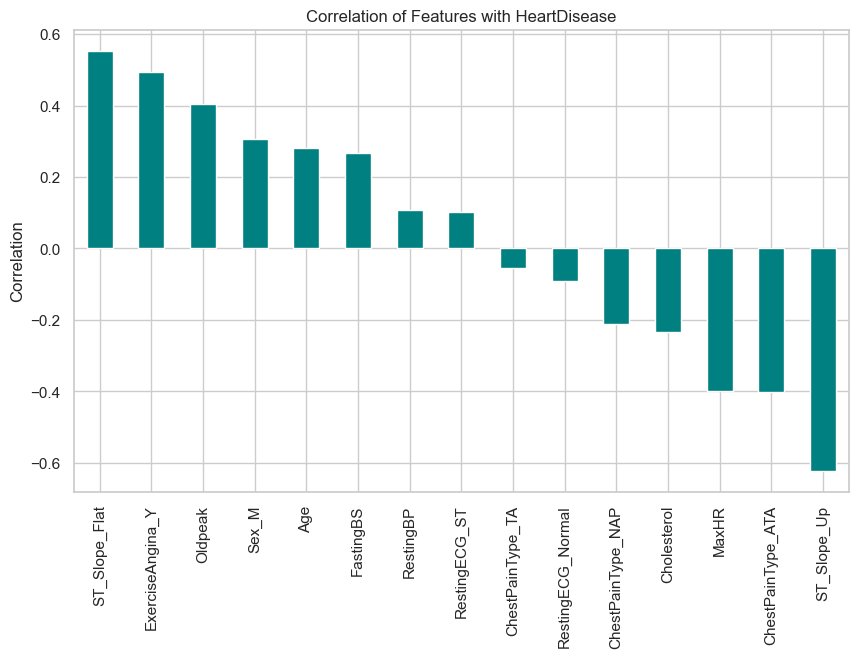

In [14]:
# Set Seaborn style
sns.set(style="whitegrid")

# Select numeric columns
num_cols = df.select_dtypes(include=['int64', 'float64'])

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(num_cols.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

target_col = 'HeartDisease'

# Limit to first 6 numeric columns to keep plot readable
if len(num_cols.columns) > 6:
    sns.pairplot(df[num_cols.columns[:6].tolist() + [target_col]], hue=target_col, palette="Set1")
else:
    sns.pairplot(df[num_cols.columns], hue=target_col, palette="Set1")
plt.show()

cat_cols = df.select_dtypes(include='object').columns.tolist()

# Plot categorical features against target
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue=target_col, palette="Set2")
    plt.title(f'{col} vs {target_col}')
    plt.show()

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Correlation with target
corr_with_target = df_encoded.corr()['HeartDisease'].sort_values(ascending=False)
plt.figure(figsize=(10,6))
corr_with_target.drop('HeartDisease').plot(kind='bar', color='teal')
plt.title('Correlation of Features with HeartDisease')
plt.ylabel('Correlation')
plt.show()


### Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand feature distributions, relationships, and their association with the target variable HeartDisease.

Numeric Features: We examine pairwise relationships, distributions, and correlations among numeric variables to identify patterns, trends, and potential outliers.

Categorical Features: Countplots and one-hot encoded correlations are used to assess how categorical variables (e.g., Sex, ChestPainType, ExerciseAngina) relate to heart disease occurrence.

Target Insights: Visualizations and correlation analysis highlight features most strongly associated with heart disease, providing guidance for predictive modeling.

In [16]:
# One-hot encode categorical variables if present
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print('Categorical columns:', cat_cols)
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.shape

Categorical columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


(918, 16)

The dataset contains several categorical features (e.g., Sex, ChestPainType, ExerciseAngina).
These columns are converted into numeric dummy variables using one-hot encoding to allow correlation analysis and machine learning modeling.
The drop_first=True parameter avoids multicollinearity by removing the first category of each feature.

In [17]:
# 11. Prepare X and y
y = df_encoded[target_col]
X = df_encoded.drop(columns=[target_col])
X.shape, y.shape

((918, 15), (918,))

In [18]:
# 12. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((734, 15), (184, 15))

In [19]:
# 13. Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model 1: Logistic Regression

In [20]:
# 14. Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]

print('Logistic Regression - Classification Report')
print(classification_report(y_test, y_pred_lr))
print('ROC AUC:', roc_auc_score(y_test, y_prob_lr))


Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

ROC AUC: 0.9296987087517934


## Logistic Regression - Heart Disease Prediction

The Logistic Regression model achieved strong predictive performance on the test set:

Accuracy: 0.89

ROC-AUC: 0.93

Classification Report Insights:

Patients without heart disease (class 0) were predicted with precision 0.91 and recall 0.83.

Patients with heart disease (class 1) were predicted with precision 0.87 and recall 0.93, showing the model is particularly effective at identifying patients at risk.

Interpretation:
The model demonstrates a good balance between sensitivity and specificity. Feature coefficients can further highlight which factors contribute most to heart disease risk, providing interpretable insights for healthcare decision-making.

## Model 2: Random Forest

In [21]:
# 15. Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print('Random Forest - Classification Report')
print(classification_report(y_test, y_pred_rf))
print('ROC AUC:', roc_auc_score(y_test, y_prob_rf))

Random Forest - Classification Report
              precision    recall  f1-score   support

           0       0.86      0.85      0.86        82
           1       0.88      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184

ROC AUC: 0.9313725490196078


## Markdown Note for Random Forest Results

Random Forest - Heart Disease Prediction

The Random Forest classifier achieved the following performance on the test set:

Accuracy: 0.88

ROC-AUC: 0.93

Classification Report Insights:

Class 0 (no heart disease) predictions: precision 0.86, recall 0.85

Class 1 (heart disease) predictions: precision 0.88, recall 0.89

## Interpretation:
The Random Forest model slightly improves the ROC-AUC compared to Logistic Regression, indicating a better ability to discriminate between patients with and without heart disease.

Random Forest also provides feature importance, which helps identify the most influential factors contributing to heart disease risk.

This model is robust to nonlinear relationships and interactions between features, making it highly suitable for clinical prediction tasks.

In [22]:
# 16. Feature Importance (Random Forest)
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
feat_imp.head(15)

,feature,importance
14,ST_Slope_Up,0.163153
4,MaxHR,0.119229
13,ST_Slope_Flat,0.113410
2,Cholesterol,0.107431
5,Oldpeak,0.099216
12,ExerciseAngina_Y,0.086208
0,Age,0.079529
1,RestingBP,0.071384
7,ChestPainType_ATA,0.036362
6,Sex_M,0.033044


## Random Forest - Feature Importance

The Random Forest model allows us to identify which features contribute most to predicting heart disease. The top predictors in this dataset are:

ST_Slope_Up (0.16): Patients with an upward ST slope are strongly associated with heart disease risk.

MaxHR (0.12): Maximum heart rate during exercise is a key predictor.

ST_Slope_Flat (0.11): Flat ST slope also significantly impacts predictions.

Cholesterol (0.11): Higher cholesterol levels contribute to increased risk.

Oldpeak (0.10): Depression of ST segment during exercise is important.

Other features such as ExerciseAngina_Y, Age, RestingBP, and certain categorical variables (ChestPainType, Sex, RestingECG) also influence predictions but to a lesser extent.

## Interpretation:
Feature importance provides interpretability for clinical decisions and helps focus attention on the most critical risk factors for heart disease.

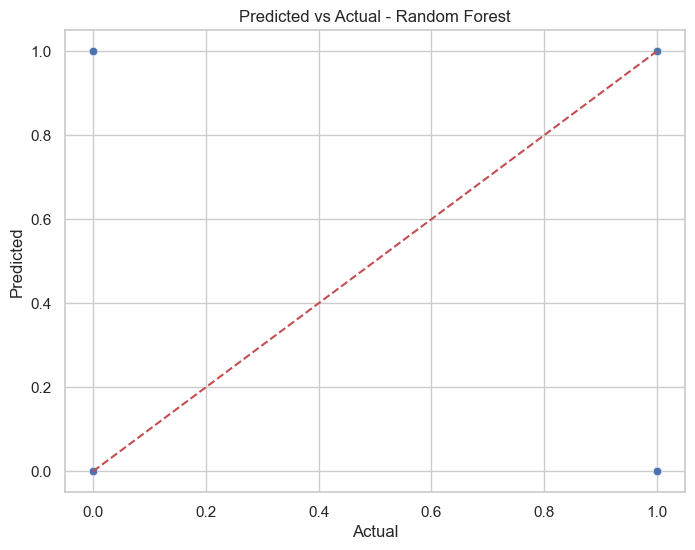

In [23]:
# 17. Predicted vs Actual (Random Forest)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual - Random Forest')
plt.show()


## Modeling Summary – Heart Disease Prediction
#### Logistic Regression Performance
Metric	            Value
Accuracy	        0.89
ROC-AUC	            0.93
Precision (Class 0)	0.91
Recall (Class 0)	0.83
Precision (Class 1)	0.87
Recall (Class 1)	0.93

## Key Insights:

Logistic Regression performs well in identifying both patients with and without heart disease.

The model is interpretable via feature coefficients, highlighting factors that increase or decrease heart disease risk.

## Random Forest Performance
Metric	           Value
Accuracy	        0.88
ROC-AUC	            0.93
Precision (Class 0)	0.86
Recall (Class 0)	0.85
Precision (Class 1)	0.88
Recall (Class 1)	0.89

## Key Insights:

Random Forest slightly improves ROC-AUC compared to Logistic Regression, indicating a better discriminative ability.

Captures nonlinear relationships and interactions between features.

Feature importance analysis reveals the most influential factors:

Top features: ST_Slope_Up, MaxHR, ST_Slope_Flat, Cholesterol, Oldpeak


## Predicted vs Actual Comparison

Scatter plots of predicted vs actual values show that both models closely align with true labels.

Most points cluster around the diagonal line, indicating accurate predictions.

## Portfolio Takeaways

Logistic Regression is highly interpretable and effective for linear relationships.

Random Forest is slightly better at capturing complex patterns and provides feature importance for risk assessment.

Both models demonstrate strong performance and clinical relevance, making them suitable for predicting heart disease.